<a href="https://colab.research.google.com/github/Slautin/2025_Attention/blob/main/2_Attention_VAE_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2025 Attention and SHAP: direct prediction

**Notebook 2/3**

06/03/2025

- Author: *Boris Slautin*
- Idea: *Sergei V Kalinin* and *Utkarsh Pratiush*
- Transformer model: *Utkarsh Pratiush*
- Sample: *Hiroshi Funakubo*
- Dataset: *Yongtao Liu*

In [ ]:
!pip install --upgrade git+https://github.com/ziatdinovmax/atomai.git

  Cloning https://github.com/ziatdinovmax/atomai.git to /tmp/pip-req-build-ave1724z
  Running command git clone --filter=blob:none --quiet https://github.com/ziatdinovmax/atomai.git /tmp/pip-req-build-ave1724z
  Resolved https://github.com/ziatdinovmax/atomai.git to commit bc1297eef086fd15e08887f6730ee92f98f073c9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

import h5py
import re
from glob import glob

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
np.random.seed(42)
torch.manual_seed(42)

import atomai as aoi
from atomai import utils
#import pyroved as pv

from sklearn.model_selection import train_test_split

In [ ]:
#@title functions for saving data

def convert_to_supported_dtype(arr):
    # Check if array has an object dtype
    if arr.dtype == np.dtype('O'):
        # Attempt conversion to a compatible type (if possible)
        try:
            return arr.astype(np.float64)  # Change to a compatible type (e.g., float)
        except ValueError:
            raise ValueError(f"Cannot convert array '{arr}' to a supported dtype.")
    return arr

def save_dict_to_hdf5(file_path, data_dict):
    def save_data(group, data):
        for key, value in data.items():
            if isinstance(value, dict):
                subgroup = group.create_group(key)
                save_data(subgroup, value)
            elif isinstance(value, np.ndarray):
                # Check and convert object dtype arrays if needed
                value = convert_to_supported_dtype(value)
                group.create_dataset(key, data=value)
            elif isinstance(value, int):
              value = np.array([value, ])
              value = convert_to_supported_dtype(value)
              group.create_dataset(key, data=value)
            else:
                group.create_dataset(key, data=value)
    with h5py.File(file_path, 'w') as f:
        save_data(f, data_dict)

def load_hdf5_to_dict(file_path):
    def load_data(group):
        data = {}
        for key, item in group.items():
            if isinstance(item, h5py.Group):
                data[key] = load_data(item)
            else:
                data[key] = np.array(item)
        return data

    with h5py.File(file_path, 'r') as f:
        data_dict = load_data(f)

    return data_dict

In [ ]:
#functions
normalize = lambda x: (x - x.min()) / (x.max() - x.min())

def get_patches(patch_image, ws=8):
  coordinates = utils.get_coord_grid(patch_image, 1)   #grid
  pix = int(len(patch_image)+1-ws)
  features_all, coords, _ = utils.extract_subimages(patch_image, coordinates, ws)
  features_all = features_all[:,:,:,0]
  return coordinates, (features_all, coords)

# 1. Load data

In [ ]:
!gdown https://drive.google.com/file/d/1vJX_SwkxUF9RVYB9DhliKAljqI9lwGg7/view?usp=sharing --fuzzy

Downloading...
From (original): https://drive.google.com/uc?id=1vJX_SwkxUF9RVYB9DhliKAljqI9lwGg7
From (redirected): https://drive.google.com/uc?id=1vJX_SwkxUF9RVYB9DhliKAljqI9lwGg7&confirm=t&uuid=6f434f12-adfd-410c-b2a4-b858c8bcec1d
To: /content/PTO_BEPS_3um.npz
100% 62.1M/62.1M [00:00<00:00, 161MB/s]


In [ ]:
BEPS = np.load(r'PTO_BEPS_3um.npz', 'r+')

# DKL inputs
amp   = BEPS['Image_Amplitude'].astype(np.float64)
pha   = BEPS["Image_Phase"].astype(np.float64)
freq  = BEPS["Image_Frequency"].astype(np.float64)
q     = BEPS["Image_Q_Factor"].astype(np.float64)
pola  = amp * np.cos(pha)
# DKL targets
A_on  = BEPS['Image_On_Field_Loop_Area']
A_off = BEPS['Image_Off_Field_Loop_Area']
Cf    = BEPS['Image_Average_Coercive_Field']
width = BEPS['Image_Loop_Width']
DC    = BEPS['Spectra_DC_Voltage']
spec  = BEPS['Spectra_Off_Field_Loop']

# 2.1 normalize
patch_image = normalize(pola)

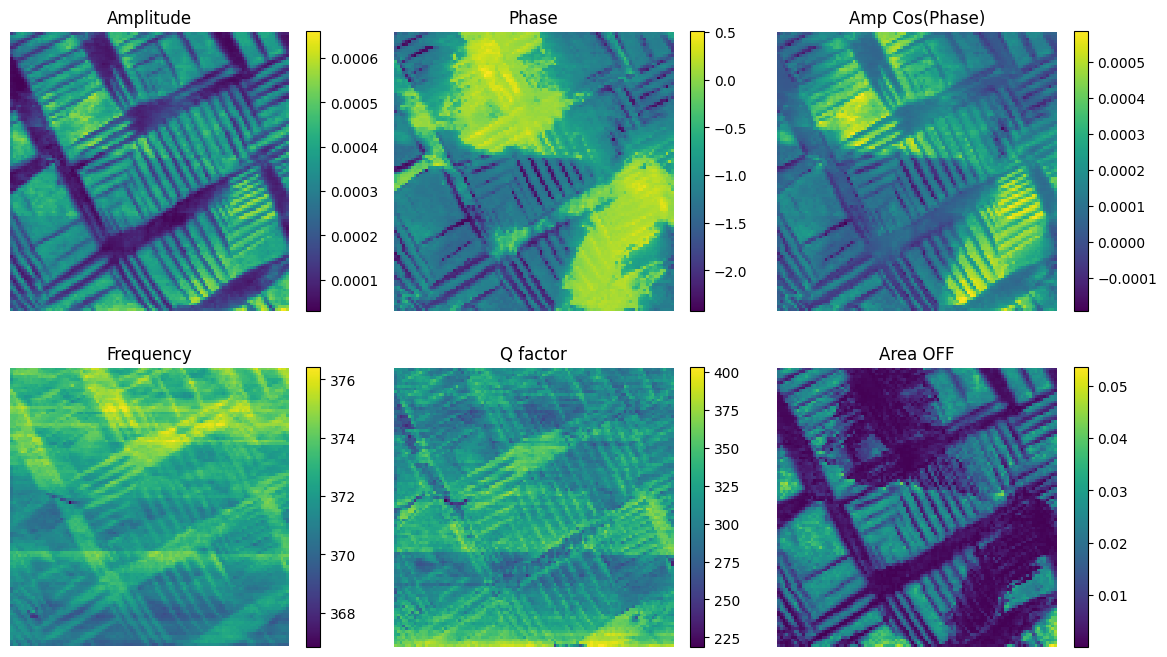

In [ ]:
size_nm = 3000 #scan size
scale = amp.shape[0] / size_nm

fig, axs = plt.subplots(2, 3, figsize=(12, 7))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.1)
# Make 4 subplots:
cm = 'viridis'
shrink = 1

im1 = axs[0, 0].imshow(amp, interpolation='nearest', cmap=cm, origin='lower')
fig.colorbar(im1, ax=axs[0, 0], shrink = shrink)
axs[0, 0].set_title("Amplitude")
axs[0, 0].axis('off')

im2 = axs[0, 1].imshow(pha, interpolation='nearest', cmap=cm, origin='lower')
fig.colorbar(im2, ax=axs[0, 1], shrink = shrink)
axs[0, 1].set_title("Phase")
axs[0, 1].axis('off')

im3 = axs[0, 2].imshow(pola, interpolation='nearest', cmap=cm, origin='lower')
fig.colorbar(im3, ax=axs[0, 2], shrink = shrink)
axs[0, 2].set_title("Amp Cos(Phase)")
axs[0, 2].axis('off')

im4 = axs[1, 0].imshow(freq/1000, interpolation='nearest', cmap=cm, origin='lower')
fig.colorbar(im4, ax=axs[1, 0], shrink = shrink)
axs[1, 0].set_title("Frequency")
axs[1, 0].axis('off')

im5 = axs[1, 1].imshow(q, interpolation='nearest', cmap=cm, origin='lower')
fig.colorbar(im5, ax=axs[1, 1], shrink = shrink)
axs[1, 1].set_title("Q factor")
axs[1, 1].axis('off')

im6 = axs[1, 2].imshow(A_off, interpolation='nearest', cmap=cm, origin='lower')
fig.colorbar(im6, ax=axs[1, 2], shrink = shrink)
axs[1, 2].set_title("Area OFF")
axs[1, 2].axis('off')

plt.show()

# 2. Data preprocessing

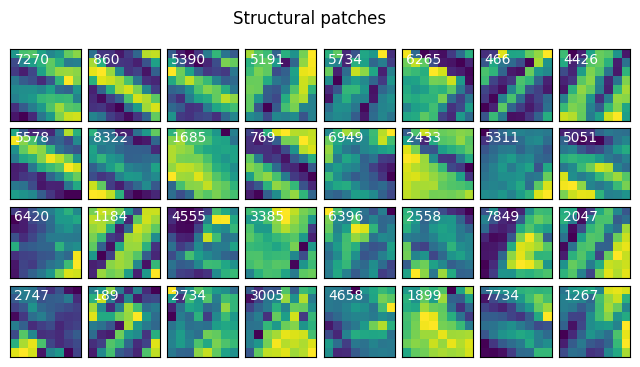

In [ ]:
# Structural image patching (RCos[Phase])

#patch window size
ws = 8

# 2.1 normalize
patch_image = normalize(pola)

# 2.2. extract patches for each point on a grid
coordinates = utils.get_coord_grid(patch_image, 1)   #grid
pix = int(len(patch_image)+1-ws)
features_all, coords, _ = utils.extract_subimages(patch_image, coordinates, ws)
features_all = features_all[:,:,:,0]

#2.3 plot examples of patches
fig, axes = plt.subplots(4, 8, figsize=(8, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

fig.suptitle('Structural patches')

for ax in axes.flat:
    i = np.random.randint(len(features_all))
    ax.imshow(features_all[i], interpolation='nearest')
    ax.text(0, 1, str(i), color='white')

In [ ]:
# Scalarizer (off-field loop area)
A_off = normalize(A_off)
Cf    = normalize(Cf)
freq = normalize(freq)

targets = [freq, A_off,Cf]

In [ ]:
#training dataset
n, d1, d2 = features_all.shape
X = features_all.reshape(n, d1*d2)  #training input: image patches

y_targ = A_off_all.reshape(-1)     #training target
y_targ = normalize(y_targ)

y = y_targ.reshape(-1)
X.shape, y.shape

NameError: name 'A_off_all' is not defined

In [ ]:
size_nm = 2000 #scan size
scale = amp.shape[0] / size_nm

origin = 0.05*patch_image.shape[0], 0.05*patch_image.shape[1]
length = len(patch_image[0])/4
height = length/5

fig, axs = plt.subplots(1, 4, figsize=(7, 1.2), dpi=300)
fig.subplots_adjust(wspace=.25)
cm = 'cividis'

im1 = axs[0].imshow(pola*1e3, interpolation='nearest', cmap=cm, origin='lower')
cbar = fig.colorbar(im1, ax=axs[0])
cbar.ax.tick_params(labelsize=7)
axs[0].set_title(r"$ACos(\theta)$", fontsize=10)
#axs[0].axis('off')
axs[0].add_patch(patches.Rectangle(origin, length, height, color = 'white', ec='k', lw=1, fill = True))

im4 = axs[1].imshow(freq, interpolation='nearest', cmap=cm, origin='lower')
cbar = fig.colorbar(im4, ax=axs[1])
cbar.ax.tick_params(labelsize=7)
axs[1].set_title("Frequency", fontsize=10)
#axs[1].axis('off')

im6 = axs[2].imshow(A_off, interpolation='nearest', cmap=cm, origin='lower')
cbar = fig.colorbar(im6, ax=axs[2])
cbar.ax.tick_params(labelsize=7)
axs[2].set_title("Area OFF", fontsize=10)
#axs[2].axis('off')

im7 = axs[3].imshow(Cf, interpolation='nearest', cmap=cm, origin='lower')
cbar = fig.colorbar(im7, ax=axs[3])
cbar.ax.tick_params(labelsize=7)
axs[3].set_title(r"$U_c$", fontsize=10)
#axs[3].axis('off')

for ax in axs:
  ax.set_xticks([])
  ax.set_yticks([])

fig.savefig('base_image.jpg', dpi=300, bbox_inches='tight')

#4. Attention

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, dim, heads=4):
        super().__init__()
        self.dim = dim
        self.heads = heads
        self.head_dim = dim // heads
        self.to_qkv = nn.Linear(dim, dim * 3)
        self.to_out = nn.Linear(dim, dim)
        self.scale = self.head_dim ** -0.5

    def forward(self, x):
        b, n, _ = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: t.view(b, n, self.heads, self.head_dim).transpose(1, 2), qkv)
        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale
        attn = dots.softmax(dim=-1)
        out = torch.matmul(attn, v)
        out = out.transpose(1, 2).reshape(b, n, -1)
        out = self.to_out(out)
        self.attention_weights = attn# Save attention weights for visualization
        return out

class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, output_dim=1, hidden_dim=512, heads=8):
        super().__init__()
        self.embedding = nn.Linear(1, hidden_dim)
        self.pos_encoding = nn.Parameter(torch.randn(1, input_dim, hidden_dim))

        self.attention = SelfAttention(hidden_dim, heads=heads)
        self.norm1 = nn.LayerNorm(hidden_dim)

        self.ff = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.GELU(),
            nn.Linear(hidden_dim * 4, hidden_dim)
        )
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.to_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        b, n = x.shape
        x = x.unsqueeze(-1)
        x = self.embedding(x)
        x = x + self.pos_encoding
        attn_out = self.attention(x)
        x = self.norm1(x + attn_out)
        ff_out = self.ff(x)
        x = self.norm2(x + ff_out)
        x = x.mean(dim=1)########## pooling
        out = self.to_out(x)
        return out

def visualize_attention(model, spectrum, epoch, verbose=False):
    spectrum_tensor = torch.FloatTensor(spectrum).unsqueeze(0)

    with torch.no_grad():
        model.eval()
        _ = model(spectrum_tensor)
        attention_weights = model.attention.attention_weights.detach().cpu().numpy()

    avg_attention = attention_weights[0].mean(axis=0)
    attention_sum = avg_attention.sum(axis=0)
    attention_sum = attention_sum / attention_sum.max()  # Normalize
    if verbose:
      fig, axs = plt.subplots(3, 1, figsize=(14, 12))

      # Plot 1: Input spectrum
      axs[0].plot(spectrum,'o-',  color='blue')
      axs[0].set_title('Input Spectrum')
      axs[0].set_xlabel('x')
      axs[0].set_ylabel('Intensity')

      # Plot 2: Heatmap of attention
      sns.heatmap(avg_attention, cmap='viridis', ax=axs[1])
      axs[1].set_title(f'Attention Weights for EPOCH = {epoch}')
      axs[1].set_xlabel('Position')
      axs[1].set_ylabel('Query Position')

      # Plot 3: Overlay attention sum with spectrum
      axs[2].plot(spectrum, 'o-', label='Spectrum', color='blue')
      axs[2].plot(attention_sum, 'o-', label='Attention Weight', color='red', alpha=0.7)
      axs[2].set_title(f'Spectrum with Attention Weights for EPOCH = {epoch}')
      axs[2].set_xlabel('x')
      axs[2].set_ylabel('Intensity / Attention')
      axs[2].legend()

      plt.tight_layout()
      plt.show()

    return attention_sum


def train_attention_regressor(X,
                              y,
                              test_size=0.2,
                              random_state=42,
                              batch_size = 128,
                              hidden_dim = 64,
                              n_epochs = 200):

  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
  n_points = X_train.shape[1]
  print(X_train.shape)

  model = TransformerRegressor(input_dim=n_points,
                               output_dim=1,
                               hidden_dim=hidden_dim)
  model.cuda()
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  train_losses = []
  val_losses = []

  X_train_tensor = torch.FloatTensor(X_train).to('cuda')
  y_train_tensor = torch.FloatTensor(y_train).unsqueeze(1).to('cuda')
  X_val_tensor = torch.FloatTensor(X_val).to('cuda')
  y_val_tensor = torch.FloatTensor(y_val).unsqueeze(1).to('cuda')
  train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
  val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size)

  for epoch in range(n_epochs):
    print(f"Starting EPCOH = {epoch}")
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))

    # Validation
    model.eval();
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            y_pred = model(X_batch)
            val_loss += criterion(y_pred, y_batch).item()

    val_losses.append(val_loss / len(val_loader))

    print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')


  return model

def save_model_dict(res_dict, path='models_with_lists.pth'):
  m_dict = res_dict.copy()
  for k in m_dict:
    models = m_dict[k]['model']
    m_dict[k]['model'] = [model.state_dict() for model in models]
  torch.save(m_dict, path)

def load_attention_regressor(model_dict,
                             hidden_dim = 64,):
  res_dict = model_dict.copy()
  for k in model_dict:
    n_points = int(k)**2
    models = []
    for state in model_dict[k]['model']:
      model = TransformerRegressor(input_dim=n_points,
                                   output_dim=1,
                                   hidden_dim=hidden_dim)
      model.load_state_dict(state)
      models.append(model)
    res_dict[k]['model'] = models
  return res_dict




##train **model**

In [ ]:

ws_list = [3, 5, 7, 9, 11, 13] #choose descriptor size

full_res = {}
for ws in ws_list:
  _, (X, coords_ws) = get_patches(patch_image, ws=ws)

  full_res[str(ws)] = {'X': X,
                       'coords': coords_ws,
                       'pred': [],
                       'att_w': [],
                       'model': [],
                       }

  n, d1, d2 = X.shape
  X = X.reshape(n, d1*d2)

  for targ in targets:
    y = targ[*coords_ws.astype(int).T].flatten()
    m = train_attention_regressor(X, y, n_epochs=200)

    #m.cuda()
    m.cpu()
    pred = m(torch.Tensor(X).to('cpu'))

    #attention
    att = m.attention.attention_weights.detach().cpu().numpy()
    sum_att = att.mean(1).sum(axis=1)
    sum_att = sum_att/sum_att.max(1)[np.newaxis,:].T

    full_res[str(ws)]['pred'].append(pred.detach().numpy())
    full_res[str(ws)]['att_w'].append(sum_att)
    full_res[str(ws)]['model'].append(m)

save_model_dict(full_res, path='3_image.pth') #save trained model

(7683, 9)


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

## load model

In [ ]:
state_dicts = torch.load('3_image_shap.pth', weights_only=False) #upload trained model and parse dictionary
ws_list = sorted(list(state_dicts.keys()), key=int)

In [ ]:
full_res = load_attention_regressor(state_dicts)

In [ ]:
full_rmse = []
for k in full_res:
  rmse_l = []
  coords_ws = full_res[k]['coords'].astype(int)
  for i, t in enumerate(targets):
    gt = t[tuple(coords_ws.astype(int).T)]
    pred = full_res[k]['pred'][i]
    rmse = np.sqrt(np.mean((gt - pred) ** 2))
    rmse_l.append(rmse)
  full_rmse.append(rmse_l)

full_rmse = np.array(full_rmse).T


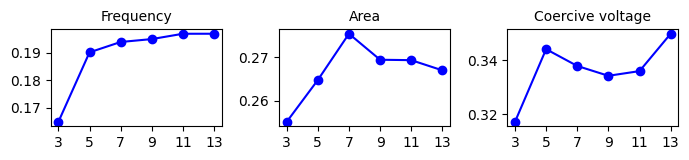

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(7, 1.7))

ax[0].plot(ws_list, full_rmse[0], 'o-', c='b')
ax[0].set_title('Frequency', fontsize=10)
ax[1].plot(ws_list, full_rmse[1], 'o-', c='b')
ax[1].set_title('Area', fontsize=10)
ax[2].plot(ws_list, full_rmse[2], 'o-', c='b')
ax[2].set_title('Coercive voltage', fontsize=10)

# for _ in ax:
#   _.set_xlim(5,15)

plt.tight_layout()

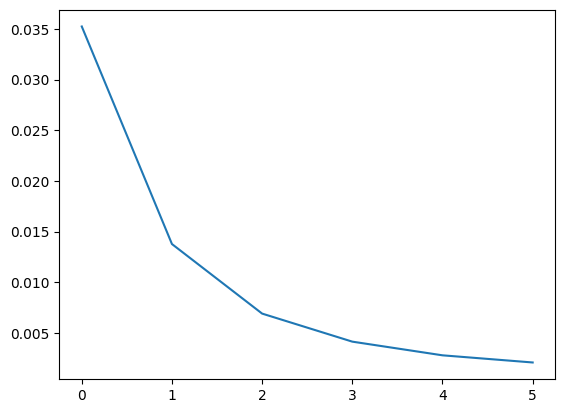

In [ ]:
 plt.plot(full_rmse[2] /np.array(ws_list, dtype=float)**2)

Text(0, 0.5, 'GT')

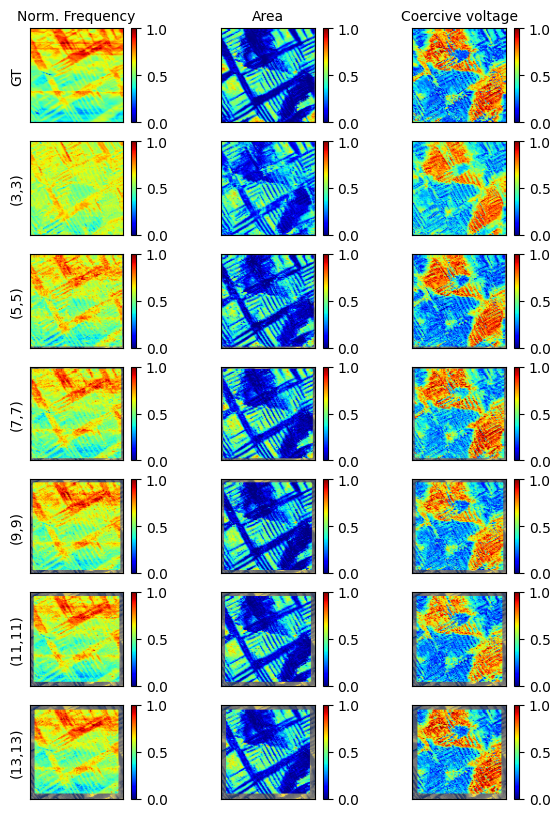

In [ ]:
i = 0 #choose ws from (3, 5, 8, 10)
#print(ws_list[i])

fig, ax = plt.subplots(len(ws_list)+1, 3, figsize=(7,10))

res_dict = full_res[str(ws_list[i])]
coords_ws = res_dict['coords'].astype(int)
pred = res_dict['pred']

for _ in ax.flatten():
  _.imshow(patch_image,
           cmap='cividis',
           origin='lower')
  _.set_xticks([])
  _.set_yticks([])

for i, ax_ in enumerate(ax[0]):
  t = targets[i]
  im = ax_.scatter(coords_ws.T[1],
              coords_ws.T[0],
              s=.3,
              c=t[tuple(coords_ws.astype(int).T)],
              cmap='jet',
              vmin=0,
              vmax=1)
  plt.colorbar(im)


for j, ax__ in enumerate(ax[1:]):
  res_dict = full_res[str(ws_list[j])]
  coords_ws = res_dict['coords'].astype(int)
  pred = res_dict['pred']

  ax[j+1,0].set_ylabel(f'({ws_list[j]},{ws_list[j]})')
  for i, ax_ in enumerate(ax__):
    im = ax_.scatter(coords_ws.T[1],
                coords_ws.T[0],
                s=.3,
                c=pred[i].flatten(),
                cmap='jet',
                vmin=0,
                vmax=1)
    plt.colorbar(im)

ax[0,0].set_title('Norm. Frequency', fontsize=10)
ax[0,1].set_title('Area', fontsize=10)
ax[0,2].set_title('Coercive voltage', fontsize=10)

ax[0,0].set_ylabel('GT')

#fig.savefig('gt_pred_direct_tranformer.jpg', dpi=300, bbox_inches='tight')

# SHAP

In [ ]:
import shap

def wrapped_model(x_numpy):
    m.cuda()
    m.eval()
    with torch.no_grad():
        x_tensor = torch.tensor(x_numpy, dtype=torch.float32).to('cuda')  # shape: (batch, input_dim)
        output = m(x_tensor)  # shape: (batch, 1)
        return output.cpu().to('cpu').numpy().reshape(-1)  # shape: (batch,)


In [ ]:
for i in range(len(ws_list)-2):
  print(ws_list[i])

3
5
7
9


In [ ]:
full_res_shap = full_res.copy()


for i in range(len(ws_list)-2):#choose the ws from the ws_list
  print(ws_list[i])
  full_res_shap[str(ws_list[i])]['shap'] = []

  for j in range(len(targets)):
    print(f'Target_{j}')

    X = full_res[str(ws_list[i])]['X']
    indexes = np.random.choice(np.arange(len(X)), size=100, replace=False)
    n, d1, d2 = X.shape
    X = X.reshape(n, d1*d2)
    att = full_res[str(ws_list[i])]['att_w'][j]

    m = full_res[str(ws_list[i])]['model'][j]
    m.cpu()
    background = shap.kmeans(X, 25)
    explainer = shap.KernelExplainer(wrapped_model, background)  # background set

    dataset = TensorDataset(torch.tensor(X))
    dataloader = DataLoader(dataset, batch_size=1000)
    shap_val = []
    #for batch in dataloader:
    sh_v = explainer.shap_values(torch.tensor(X).numpy(), nsamples=100)

      #shap_val.append(sh_v)
    shap_val = np.array(sh_v)
    shap_val = shap_val.reshape(-1,shap_val.shape[-1])
    print(shap_val.shape)



    full_res_shap[str(ws_list[i])]['shap'].append(shap_val)


3
Target_0


  0%|          | 0/9604 [00:00<?, ?it/s]

(9604, 9)
Target_1


  0%|          | 0/9604 [00:00<?, ?it/s]

(9604, 9)
Target_2


  0%|          | 0/9604 [00:00<?, ?it/s]

(9604, 9)
5
Target_0


  0%|          | 0/9216 [00:00<?, ?it/s]

(9216, 25)
Target_1


  0%|          | 0/9216 [00:00<?, ?it/s]

(9216, 25)
Target_2


  0%|          | 0/9216 [00:00<?, ?it/s]

(9216, 25)
7
Target_0


  0%|          | 0/8836 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=3.303e-04, with an active set of 9 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=9.239e-04, with an active set of 8 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


(8836, 49)
Target_1


  0%|          | 0/8836 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=1.067e-03, with an active set of 4 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=6.089e-04, with an active set of 9 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(


(8836, 49)
Target_2


  0%|          | 0/8836 [00:00<?, ?it/s]

(8836, 49)
9
Target_0


  0%|          | 0/8464 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 7 iterations, i.e. alpha=1.119e-03, with an active set of 7 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(


(8464, 81)
Target_1


  0%|          | 0/8464 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=4.314e-03, with an active set of 1 regressors, and the smallest cholesky pivot element being 7.300e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=1.038e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=6.932e-04, with an active set of 8 regressors, and the smallest cholesky pivot element being 4

(8464, 81)
Target_2


  0%|          | 0/8464 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 6 iterations, i.e. alpha=1.204e-03, with an active set of 6 regressors, and the smallest cholesky pivot element being 4.215e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 9 iterations, i.e. alpha=2.219e-03, with an active set of 9 regressors, and the smallest cholesky pivot element being 5.960e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 8 iterations, i.e. alpha=3.300e-03, with an active set of 8 regressors, and the smallest cholesky pivot element being 5

(8464, 81)


In [ ]:
save_model_dict(full_res, path='3_image_shap_final.pth') #save the dictionary extended by the shap values

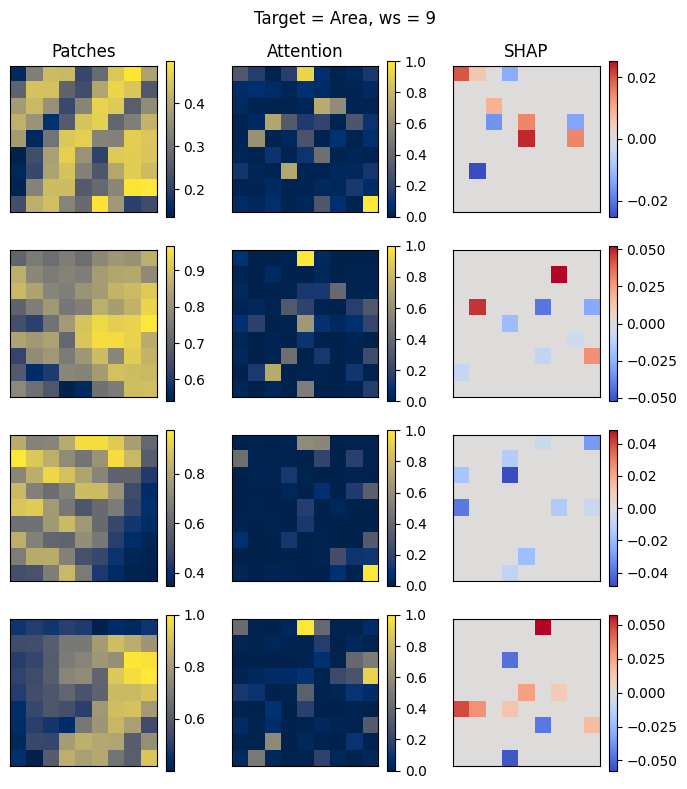

In [ ]:
i = 3 #from ws-list
j = 1 # from targets ['Frequency', 'Area', 'Coercive']

t_labels = ['Frequency', 'Area', 'Coercive']

X = full_res[str(ws_list[i])]['X']
n, d1, d2 = X.shape
X = X.reshape(n, d1*d2)
att = full_res[str(ws_list[i])]['att_w'][j]
sh_v = full_res[str(ws_list[i])]['shap'][j]

indexes = np.random.choice(np.arange(len(X)), size=4, replace=False)

fig, ax = plt.subplots(4, 3, figsize=(7, 8))
fig.suptitle(f'Target = {t_labels[j]}, ws = {ws_list[i]}')

for k,ind in enumerate(indexes):
#   sh_v = explainer.shap_values(X[ind])


  im = ax[k,0].imshow(X[ind].reshape(d1, d2),
               cmap='cividis')
  plt.colorbar(im)
  im= ax[k,1].imshow(att[ind].reshape(d1, d2),
               cmap='cividis', vmax=1, vmin=0)
  plt.colorbar(im)
  im = ax[k,2].imshow(sh_v[ind].reshape(d1, d2),
                 cmap='coolwarm',
                 vmin=-max(abs(sh_v[ind])),
                 vmax=max(abs(sh_v[ind]))  )
  plt.colorbar(im)

for _ in ax.flatten():
  _.set_xticks([])
  _.set_yticks([])

ax[0,0].set_title('Patches')
ax[0,1].set_title('Attention')
ax[0,2].set_title('SHAP')

plt.tight_layout()

fig.savefig(f'shap_attent_patches_{t_labels[j]}_ws{ws_list[i]}.jpg', bbox_inches='tight')

In [ ]:
state_dicts = torch.load(r'3_image_shap.pth', weights_only=False,  map_location=torch.device('cpu'))
full_res = load_attention_regressor(state_dicts)
ws_list = sorted(list(full_res.keys()), key=int)
ws_list

['3', '5', '7', '9', '11', '13']

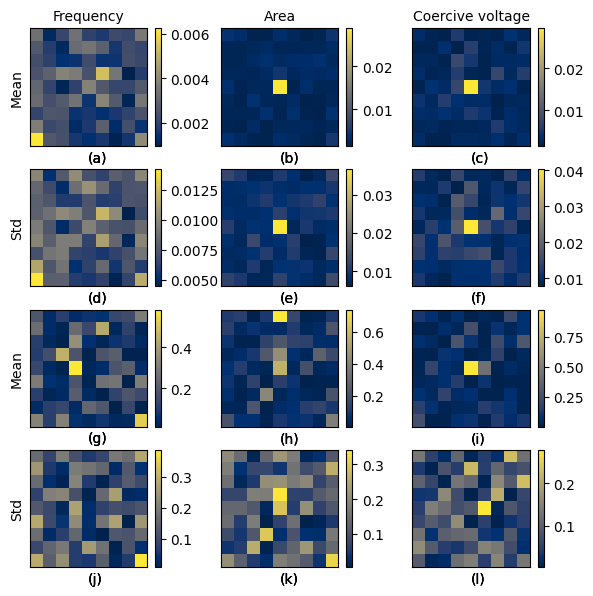

In [ ]:
wss = 9
#figure for the article
import string
alphabet_list = list(string.ascii_lowercase[:12])

fig, ax = plt.subplots(4,3, figsize=(7,7))

res = full_res_shap[str(wss)]
sh_v_l = res['shap']
att_w_list = res['att_w']

for i in range(len(sh_v_l)):
  sh = sh_v_l[i]
  att = att_w_list[i]

  im = ax[0,i].imshow(abs(sh).mean(0).reshape(wss,wss), cmap='cividis')
  plt.colorbar(im)

  im = ax[1,i].imshow(abs(sh).std(0).reshape(wss,wss), cmap='cividis')
  plt.colorbar(im)

  im=ax[2,i].imshow(att.mean(0).reshape(wss,wss), cmap='cividis')
  plt.colorbar(im)

  im=ax[3,i].imshow(att.std(0).reshape(wss,wss), cmap='cividis')
  plt.colorbar(im)

  for j,_ in enumerate(ax.flatten()):
    _.set_xticks([])
    _.set_yticks([])
    _.text(4, 9.7, f'({alphabet_list[j]})', fontsize=10)

ax[0,0].set_ylabel('Mean', fontsize=10)
ax[1,0].set_ylabel('Std', fontsize=10)
ax[2,0].set_ylabel('Mean', fontsize=10)
ax[3,0].set_ylabel('Std', fontsize=10)

ax[0,0].set_title('Frequency', fontsize=10)
ax[0,1].set_title('Area', fontsize=10)
ax[0,2].set_title('Coercive voltage', fontsize=10)

#plt.tight_layout()
fig.savefig('im_targ_9.jpg', dpi=300, bbox_inches='tight')

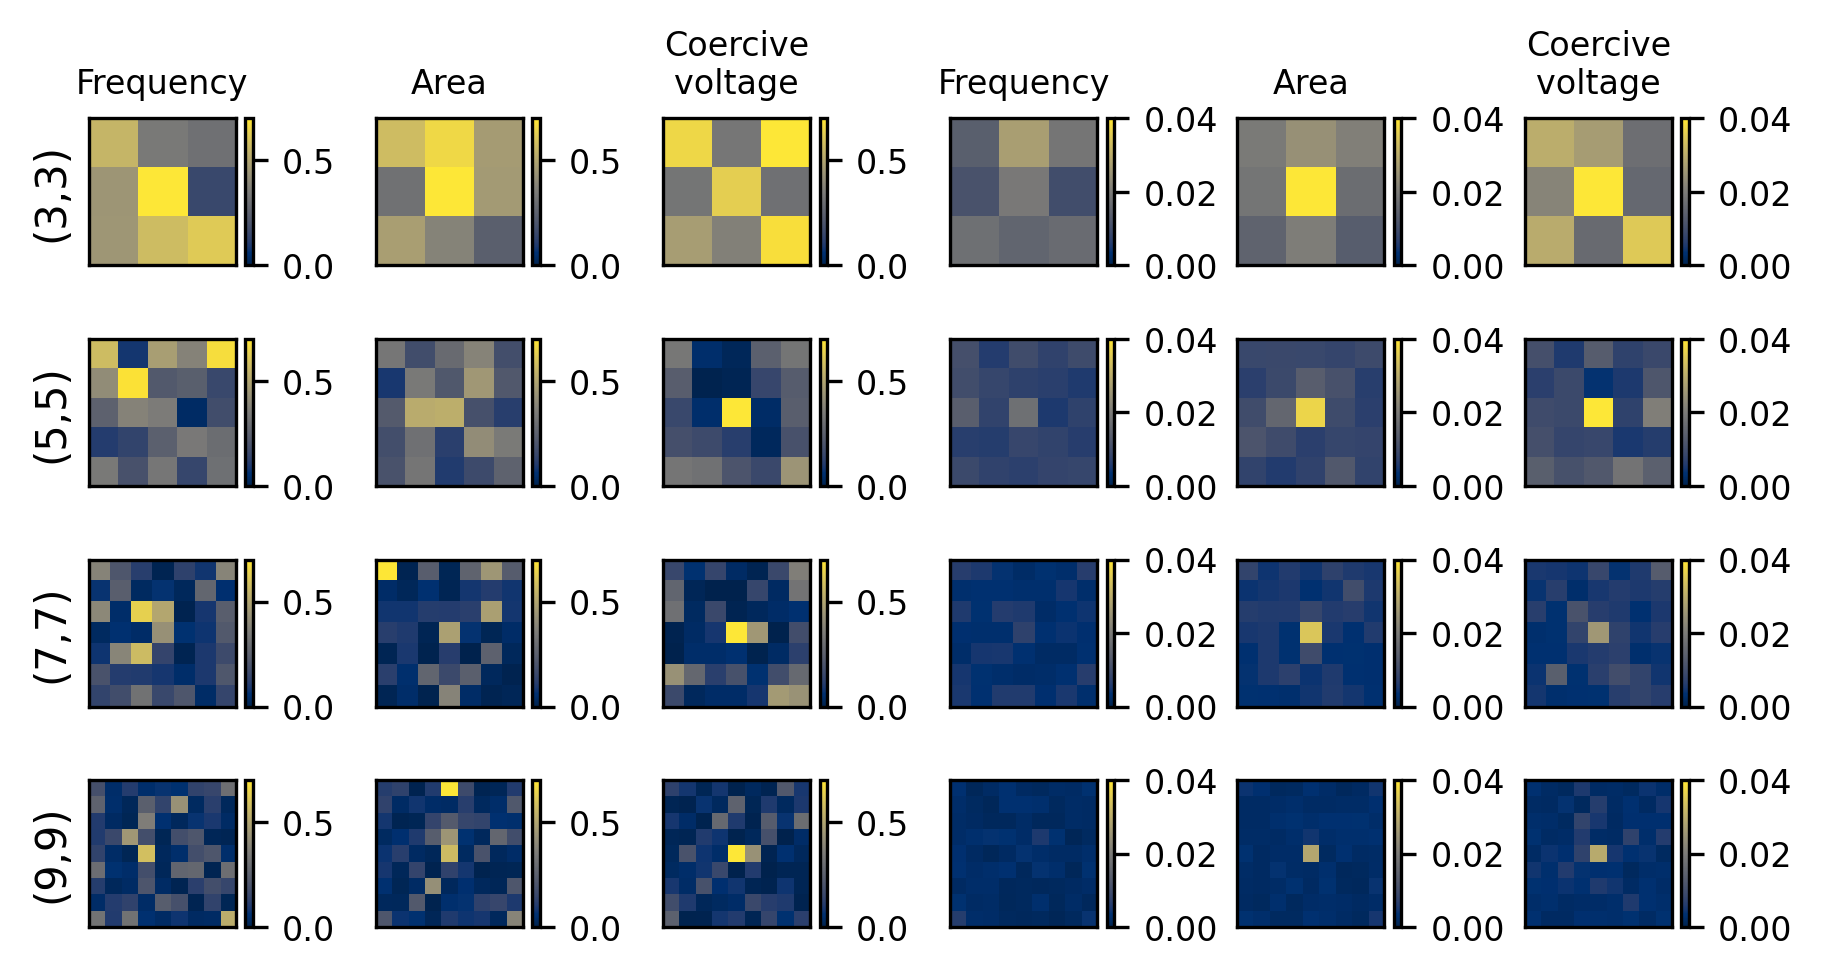

In [ ]:
import string
alphabet_list = list(string.ascii_lowercase[:6])

fig, ax = plt.subplots(4, 6, figsize=(7,3.5), dpi=300)
plt.subplots_adjust(wspace=.5, hspace=.5)

for k in range(4):
  ws = int(ws_list[k])
  res = full_res_shap[ws_list[k]]
  sh_v_l = res['shap']
  att_w_list = res['att_w']

  ax[k,0].set_ylabel(f'({ws},{ws})')

  for i in range(len(sh_v_l)):
    sh = sh_v_l[i]
    att = att_w_list[i]

    im = ax[k,i+3].imshow(abs(sh).mean(0).reshape(ws,ws), cmap='cividis', vmin=0, vmax=.04)
    cbar = plt.colorbar(im)
    cbar.ax.tick_params(labelsize=8)

    im=ax[k,i].imshow(att.mean(0).reshape(ws,ws), cmap='cividis', vmin=0, vmax=.7)
    cbar = plt.colorbar(im)
    cbar.ax.tick_params(labelsize=8)


    for j,_ in enumerate(ax.flatten()):
      _.set_xticks([])
      _.set_yticks([])


ax[0,0].set_title('Frequency', fontsize=8)
ax[0,1].set_title('Area', fontsize=8)
ax[0,2].set_title('Coercive\nvoltage', fontsize=8)
ax[0,3].set_title('Frequency', fontsize=8)
ax[0,4].set_title('Area', fontsize=8)
ax[0,5].set_title('Coercive\nvoltage', fontsize=8)

fig.savefig('average_prediction.jpg', bbox_inches='tight', dpi=300)

In [ ]:
def intensity_decrease(array):
  M = array.shape[0]
  N = array.shape[1]

  # Center coordinates
  cx, cy = N // 2, N // 2

  # Create distance map (same for all examples)
  y, x = np.indices((N, N))
  r = np.sqrt((x - cx)**2 + (y - cy)**2)
  r_int = r.astype(int)
  r_max = r_int.max()

  # Store mean and std for each radius
  mean_profile = np.zeros(r_max + 1)
  std_profile = np.zeros(r_max + 1)

  # Flatten array for easier masking
  array_flat = array.reshape(M, -1)  # shape (M, N*N)
  r_flat = r_int.flatten()           # shape (N*N)

  for i in range(r_max + 1):
      mask = (r_flat == i)           # shape (N*N,)
      if np.any(mask):
          pixels = array_flat[:, mask]  # shape (M, num_pixels_at_r)
          all_values = pixels.flatten() # all pixel values at this radius across all examples
          mean_profile[i] = all_values.mean()
          std_profile[i] = all_values.std()

  # Plot
  r_values = np.arange(r_max + 1)
  return [r_values, mean_profile, std_profile]

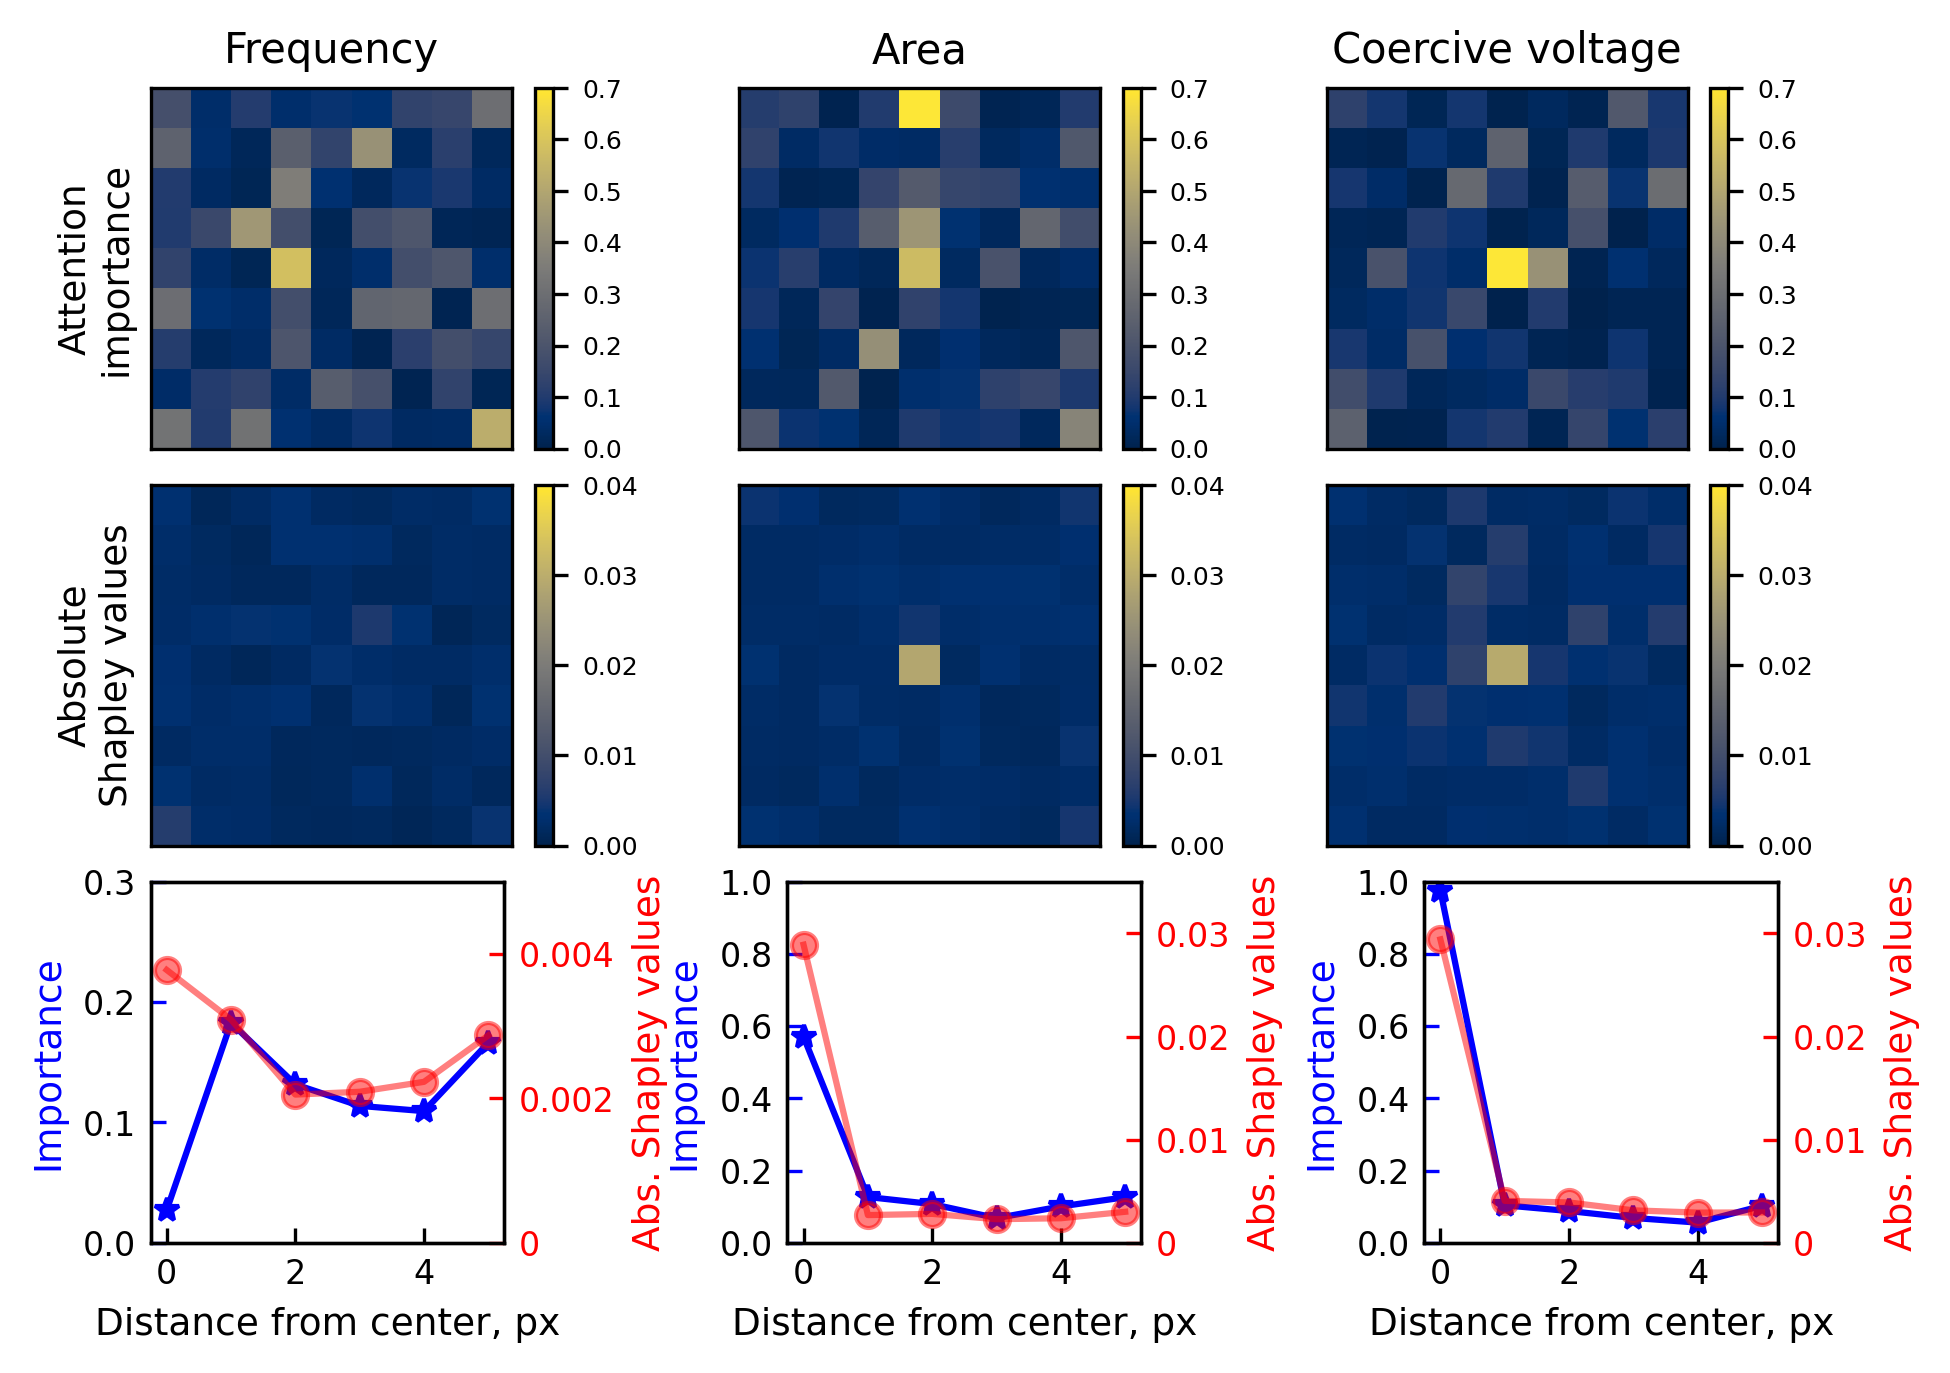

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

ns = 9
res = full_res_shap[str(ns)]
sh_v_l = res['shap']
att_w_list = res['att_w']

# Create figure
fig = plt.figure(figsize=(7, 5), dpi=300)

# Use GridSpec with custom hspace between rows
gs = gridspec.GridSpec(3, 3, hspace=0.1, wspace=.3)  # adjust hspace/wspace as needed
inner_gs = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[2,:], wspace=.8)

# Loop through columns (3 total)
for i in range(3):
    sh = np.abs(sh_v_l[i])
    att = att_w_list[i]
    r_sh, m_sh, std_sh = intensity_decrease(sh.reshape(-1, ns, ns))
    r_att, m_att, std_att = intensity_decrease(att.reshape(-1, ns, ns))

    # Row 0: attention maps
    ax0 = fig.add_subplot(gs[0, i])
    im0 = ax0.imshow(att.mean(0).reshape(ns, ns), cmap='cividis', vmin=0, vmax=.7)
    ax0.set_xticks([]); ax0.set_yticks([])
    if i == 0: ax0.set_title('Frequency', fontsize=10)
    if i == 1: ax0.set_title('Area', fontsize=10)
    if i == 2: ax0.set_title('Coercive voltage', fontsize=10)
    cbar0 = plt.colorbar(im0, ax=ax0)
    cbar0.ax.tick_params(labelsize=6)
    if i==0:
      ax0.set_ylabel("Attention\nimportance", fontsize=9)

    # Row 1: shap maps
    ax1 = fig.add_subplot(gs[1, i])
    im1 = ax1.imshow(abs(sh).mean(0).reshape(ns, ns), cmap='cividis', vmin=0, vmax=.04)
    ax1.set_xticks([]); ax1.set_yticks([])
    cbar1 = plt.colorbar(im1, ax=ax1)
    cbar1.ax.tick_params(labelsize=6)
    if i==0:
      ax1.set_ylabel("Absolute\nShapley values", fontsize=9)



    # Row 2: radial plots
    ax2 = fig.add_subplot(inner_gs[i])
    ax2.plot(r_att, m_att, '*-', c='b')
    ax2.tick_params(axis='both', labelsize=8, direction='in')
    ax2.tick_params(axis='y', color='b')
    ax2.set_ylim(0,1)
    ax2.set_xlabel('Distance from center, px', fontsize=9)
    ax2.set_ylabel('Importance', color='b', fontsize=9)


    ax2_ = ax2.twinx()
    ax2_.plot(r_sh, m_sh, 'o-', c='r', alpha=0.5)
    ax2_.set_ylim(0, 0.035)
    ax2_.set_yticks([0, .01, .02, .03], [0, .01, .02, .03], c='r')
    ax2_.tick_params(axis='y', labelsize=8, direction='in', color='r')
    ax2_.set_ylabel('Abs. Shapley values', color='r', fontsize=9)
    if i==0:
      ax2.set_ylim(0,.3)
      ax2_.set_ylim(0, 0.005)
      ax2_.set_yticks([0, .002, .004], [0, .002, .004])

fig.savefig('fig2.jpg', dpi=300, bbox_inches='tight')

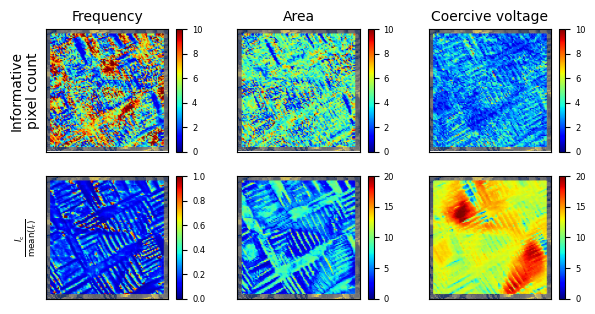

In [ ]:
ns= 9
res = full_res_shap[str(ns)]
sh_v_l = res['shap']
att_w_list = res['att_w']

threshold = .5

fig, ax = plt.subplots(2,3, figsize=(7,3.5))
att_w_list = full_res[str(ns)]['att_w']
coords = full_res[str(ns)]['coords'].astype(int)

for _ in ax.flatten():
  _.imshow(patch_image, interpolation='nearest', cmap='cividis', origin='lower')
  _.set_xticks([])
  _.set_yticks([])

for i in range(3):
  bool_att = att_w_list[i] > threshold
  sum_att = bool_att.sum(axis=1)

  rat_att = att_w_list[i][ :, 40]/np.mean(np.delete(att_w_list[i], 40, axis=1), axis=1)



  im = ax[0,i].scatter(*coords[:,::-1].T, c=sum_att, s=.3, vmax=10, vmin=0, cmap='jet')
  cbar = plt.colorbar(im)
  cbar.ax.tick_params(labelsize=6)
  if i==0:
    vmax=1
  else:
    vmax=20
  im = ax[1,i].scatter(*coords[:,::-1].T, c=rat_att, s=.3,  vmin=0, vmax=vmax, cmap='jet')
  cbar = plt.colorbar(im)
  cbar.ax.tick_params(labelsize=6)

ax[0,0].set_title('Frequency', fontsize=10)
ax[0,1].set_title('Area', fontsize=10)
ax[0,2].set_title('Coercive voltage', fontsize=10)

ax[0,0].set_ylabel('Informative\npixel count')
ax[1,0].set_ylabel(r'$\frac{I_{\mathrm{c}}}{\mathrm{mean}(I_{\mathrm{r}})}$', fontsize=9)

fig.savefig('fig3.jpg', bbox_inches='tight', dpi=300)

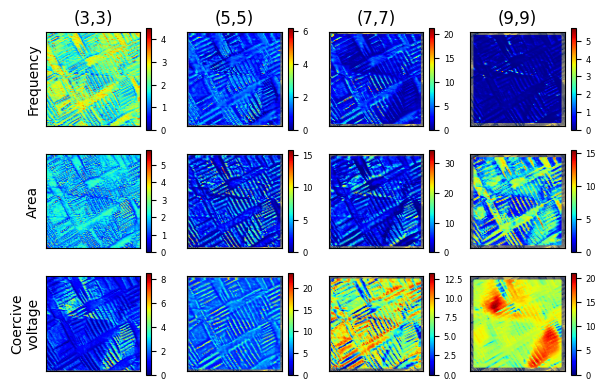

In [ ]:
threshold = .5

fig, ax = plt.subplots(3, 4, figsize=(7, 4.5))

for _ in ax.flatten():
  _.imshow(patch_image, interpolation='nearest', cmap='cividis', origin='lower')
  _.set_xticks([])
  _.set_yticks([])


for i, ws in enumerate(ws_list[:4]):
  att_w_list = full_res[ws]['att_w']
  coords = full_res[ws]['coords'].astype(int)

  for j in range(3):
    rat_att = att_w_list[j][ :, int(ws)**2//2]/np.mean(np.delete(att_w_list[j], int(ws)**2//2, axis=1), axis=1)

    im = ax[j,i].scatter(*coords[:,::-1].T, c=rat_att, s=.3,  vmin=0, cmap='jet')
    cbar = plt.colorbar(im)
    cbar.ax.tick_params(labelsize=6)

    if j==0:
      ax[j,i].set_title(f'({ws},{ws})')

ax[0,0].set_ylabel('Frequency', fontsize=10)
ax[1,0].set_ylabel('Area', fontsize=10)
ax[2,0].set_ylabel('Coercive\nvoltage', fontsize=10)

fig.savefig('fig_s4.jpg', dpi=300, bbox_inches='tight')

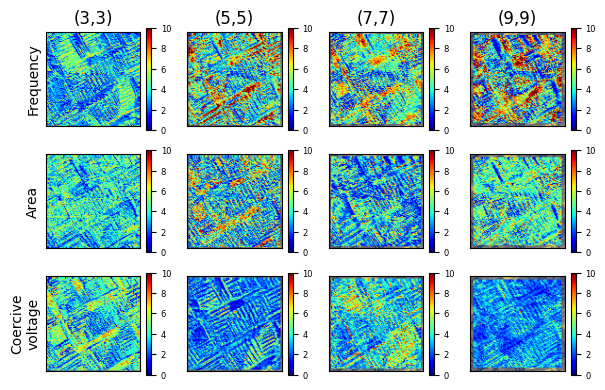

In [ ]:
threshold = .5

fig, ax = plt.subplots(3, 4, figsize=(7, 4.5))

for _ in ax.flatten():
  _.imshow(patch_image, interpolation='nearest', cmap='cividis', origin='lower')
  _.set_xticks([])
  _.set_yticks([])

summ_list = []

for i, ws in enumerate(ws_list[:4]):
  att_w_list = full_res[ws]['att_w']
  coords = full_res[ws]['coords'].astype(int)

  sum_list_ws = []
  for j in range(3):
    bool_att = att_w_list[j] > .5
    sum_att = bool_att.sum(axis=1)
    sum_list_ws.append((sum_att.mean(), sum_att.std()))

    im = ax[j,i].scatter(*coords[:,::-1].T, c=sum_att, s=.3, vmax=10, vmin=0, cmap='jet')
    cbar = plt.colorbar(im)
    cbar.ax.tick_params(labelsize=6)

    if j==0:
      ax[j,i].set_title(f'({ws},{ws})')
  summ_list.append(sum_list_ws)

ax[0,0].set_ylabel('Frequency', fontsize=10)
ax[1,0].set_ylabel('Area', fontsize=10)
ax[2,0].set_ylabel('Coercive\nvoltage', fontsize=10)

fig.savefig('fig_s3.jpg', dpi=300, bbox_inches='tight')